 # Stochastic Almgren–Chriss Optimal Execution



 This notebook extends the deterministic Almgren–Chriss framework to a stochastic setting, where asset prices evolve randomly over time and execution decisions must account for price uncertainty.

 The trader seeks to liquidate a large position over a fixed time horizon while minimizing a trade-off between execution costs and price risk.



## Stochastic Price Process

The unaffected asset price follows a diffusion with drift:

$$
dS_t = \mu\,dt + \sigma\,dW_t
$$

where:
- $\mu$ is the expected return (drift),
- $\sigma$ is the volatility,
- $W_t$ is a standard Brownian motion.

Although the drift affects expected execution proceeds, under a quadratic mean–variance objective it does not alter the optimal execution policy. The optimal control depends only on volatility and risk aversion, a known property of the Almgren–Chriss framework.

 ## Discrete-Time Setting



 Time is discretized into $N$ intervals of equal length $\Delta t = T / N$.



 The state variables evolve as:



 **Inventory dynamics**

 $$

 x_{k+1} = x_k - v_k \, \Delta t,

 $$



 **Price dynamics**

 $$

 S_{k+1} = S_k + \sigma \sqrt{\Delta t} \, \xi_k,

 \qquad \xi_k \sim \mathcal{N}(0,1).

 $$



 The control variable $v_k$ denotes the trading rate over interval $k$.



In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Time discretization
T = 1.0
N = 200
dt = T / N

# Initial inventory
X0 = 1_000_000

# Market parameters
eta = 2.5e-6          # temporary market impact
sigma = 0.02          # volatility
lam = 1e-6            # risk aversion
phi = eta / dt        # terminal inventory penalty 


# Random seed for reproducibility
np.random.seed(42)

 ## Execution Cost



 Trading at rate $v_k$ causes the execution price to deviate from the

 unaffected price due to temporary market impact.



 We assume linear temporary impact, so the execution price is



 $$

 \tilde{S}_k = S_k - \eta \, v_k.

 $$



 The total execution cost is measured via **implementation shortfall**, comparing realized proceeds against the notional value of the initial position.
 The quadratic cost term arises from multiplying linear temporary impact by traded volume over each interval.



 ## Objective Function



 The trader minimizes a mean–variance objective of the form



 $$

 \mathbb{E}[C] + \lambda \, \mathrm{Var}(C),

 $$



 where $C$ denotes total execution cost.



 In discrete time, this objective reduces to



 $$

 J =

 \mathbb{E}\!\left[

 \sum_{k=0}^{N-1} \eta \, v_k^2 \, \Delta t

 \right]

 \;+\;

 \lambda \,

 \mathbb{E}\!\left[

 \sum_{k=0}^{N-1} \sigma^2 \, x_k^2 \, \Delta t

 \right].

 $$



 The first term penalizes aggressive trading through temporary market impact,

 while the second term penalizes holding inventory under price uncertainty.



 **Remark (Permanent Market Impact).**



 In the original Almgren–Chriss framework, permanent market impact contributes

 a linear term to the expected execution cost. Under an exact liquidation

 constraint and a mean–variance objective, this term does not affect the

 optimal trading policy and only shifts the total expected cost by a constant.



 For this reason, permanent market impact is omitted in the stochastic

 formulation considered here, without loss of generality.



 ## Dynamic Programming Formulation



 Define the value function at time step $k$ as



 $$

 V_k(x) =

 \min_{\{v_j\}_{j=k}^{N-1}}

 \mathbb{E}_k \!\left[

 \sum_{j=k}^{N-1}

 \left(

 \eta \, v_j^2 + \lambda \, \sigma^2 \, x_j^2

 \right)

 \Delta t

 \right],

 $$



 subject to the inventory dynamics



 $$

 x_{j+1} = x_j - v_j \, \Delta t,

 $$



 with terminal condition



 $$
V_N(x) = \phi x^2
 $$



 This problem is a finite-horizon **stochastic linear–quadratic regulator (LQR)**.



 ## Quadratic Value Function Ansatz



 By convexity of the problem, the value function admits a quadratic form:



 $$

 V_k(x) = a_k \, x^2,

 \qquad a_k \ge 0,

 $$



 where the coefficients $\{a_k\}_{k=0}^N$ are determined by backward recursion.



 This structure leads to a linear optimal feedback control and a Riccati

 difference equation, derived in the next section.

**Terminal Liquidation Condition.**

In the stochastic formulation, exact liquidation is enforced via a terminal
quadratic penalty on remaining inventory:

$
V_N(x) = \phi x^2, \quad \phi \gg 1
$

This ensures that holding inventory at the end of the horizon is prohibitively
costly, leading to near-complete liquidation, with exact terminal liquidation enforced numerically for stability in simulations.


 ## Bellman Equation



 Let $V_k(x)$ denote the optimal value function at time step $k$ with

 inventory level $x$.



 The Bellman recursion is



 $$

 V_k(x)

 =

 \min_{v_k}

 \mathbb{E}_k \left[

 \eta v_k^2 \, \Delta t

 + \lambda \sigma^2 x^2 \, \Delta t

 + V_{k+1}(x - v_k \Delta t)

 \right],

 $$



 with terminal condition



 $$

 V_N(x) = \phi x^2


 $$



 This recursion characterizes a finite-horizon stochastic

 linear–quadratic regulator.



**Remark (Role of Drift)**

Although the unaffected price process includes a drift term, the optimal
execution policy under a mean–variance objective depends only on inventory.
The drift contributes only an additive constant to expected proceeds and
therefore does not alter the optimal control. For this reason, the value
function is expressed solely as a function of inventory.


In [46]:
def solve_stochastic_ac(N, dt, eta, sigma, lam):
    """
    Solves the stochastic Almgren–Chriss model with price drift
    via dynamic programming.
    """
    a = np.zeros(N + 1)
    kappa = np.zeros(N)

    a[N] = phi

    for k in reversed(range(N)):
        denom = eta * dt + a[k+1] * dt**2

        # Optimal feedback gain
        kappa[k] = a[k+1] * dt / denom

        # Riccati recursion with drift
        a[k] = (
            a[k+1]
            - (a[k+1]**2 * dt**2) / denom
            + lam * sigma**2 * dt
        )

    return a, kappa

 ## Optimal Feedback Control



 The optimal trading rate is linear in the current inventory:



 $$

 v_k^* = \kappa_k \, x_k,

 $$



 where the feedback gains $\kappa_k$ are determined by the Riccati recursion.



 Unlike the deterministic Almgren–Chriss solution:

 - the strategy is **closed-loop**,

 - execution adapts dynamically to realized inventory,

 - uncertainty enters through the backward recursion.



In [47]:
def simulate_execution(X0, S0, kappa, sigma, dt, N):
    """
    Simulate inventory, price, and trading rate paths under
    optimal stochastic execution.
    """
    x = np.zeros(N + 1)
    S = np.zeros(N + 1)
    v = np.zeros(N)

    x[0] = X0
    S[0] = S0

    for k in range(N):
        v[k] = kappa[k] * x[k]
        x[k+1] = x[k] - v[k] * dt
        S[k+1] = S[k] + sigma * np.sqrt(dt) * np.random.randn()

    return x, S, v

In [48]:
# Solve stochastic Almgren–Chriss via dynamic programming
a, kappa = solve_stochastic_ac(N, dt, eta, sigma, lam)

 ## Simulated Stochastic Execution Path



 We now simulate a sample path of inventory and prices under the

 optimal stochastic execution strategy.



 Inventory dynamics are deterministic conditional on the feedback

 control, while price evolves stochastically.



In [49]:
S0 = 100.0

x_path, S_path, v_path = simulate_execution(
    X0=X0,
    S0=S0,
    kappa=kappa,
    sigma=sigma,
    dt=dt,
    N=N
)

 ## Inventory Trajectory



 The inventory path reflects optimal feedback control.

 Randomness enters indirectly through the state dynamics,

 not through explicit price tracking.



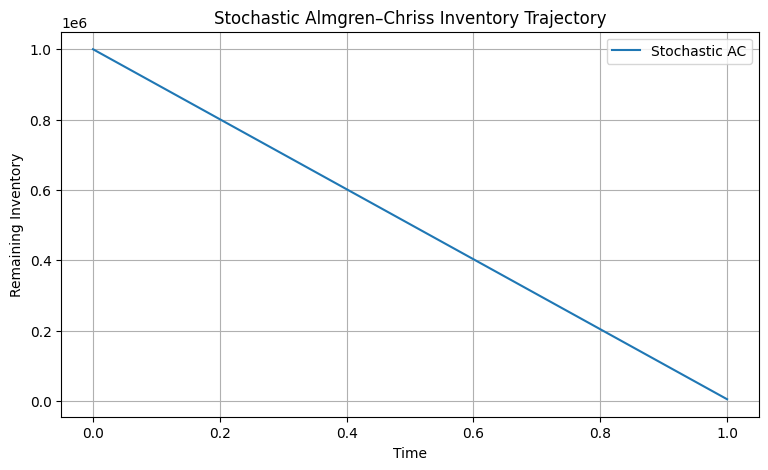

In [50]:
plt.figure(figsize=(9, 5))
plt.plot(np.arange(N + 1) * dt, x_path, label="Stochastic AC")
plt.xlabel("Time")
plt.ylabel("Remaining Inventory")
plt.title("Stochastic Almgren–Chriss Inventory Trajectory")
plt.grid(True)
plt.legend()
plt.show()

 ## Comparison with Deterministic Almgren–Chriss

 We compare the stochastic feedback strategy with the deterministic open-loop Almgren–Chriss solution.

 The deterministic strategy is pre-committed at time zero, while the stochastic strategy continuously adapts to the state.

In [51]:
def solve_ac_deterministic(N, dt, eta, sigma, lam, X0):
    """
    Deterministic Almgren–Chriss solution via quadratic programming.
    """
    L = np.tril(np.ones((N, N))) * dt

    A = 2 * eta * dt * np.eye(N) + 2 * lam * sigma**2 * dt * (L.T @ L)

    C = dt * np.ones((1, N))

    KKT = np.block([
        [A, C.T],
        [C, np.zeros((1, 1))]
    ])

    rhs = np.zeros(N + 1)
    rhs[-1] = X0

    sol = np.linalg.solve(KKT, rhs)
    return sol[:N]



In [52]:
v_det = solve_ac_deterministic(N, dt, eta, sigma, lam, X0)
L = np.tril(np.ones((N, N))) * dt
x_det = X0 * np.ones(N) - L @ v_det
x_det = np.insert(x_det, 0, X0)


**Remark (Degeneracy without Drift).**

In the absence of price drift, the stochastic execution problem reduces to
pure risk minimization, leading to immediate liquidation. Introducing a
nonzero drift restores the economic trade-off between expected returns and
inventory risk, yielding non-degenerate optimal strategies.


In [53]:
# --- Expected stochastic inventory (Monte Carlo) ---

n_paths = 500
X_paths = np.zeros((n_paths, N + 1))

for i in range(n_paths):
    x_sim, _, _ = simulate_execution(
        X0=X0,
        S0=S0,
        kappa=kappa,
        sigma=sigma,
        dt=dt,
        N=N
    )
    X_paths[i] = x_sim

# Expected inventory trajectory
x_stoch_mean = X_paths.mean(axis=0)


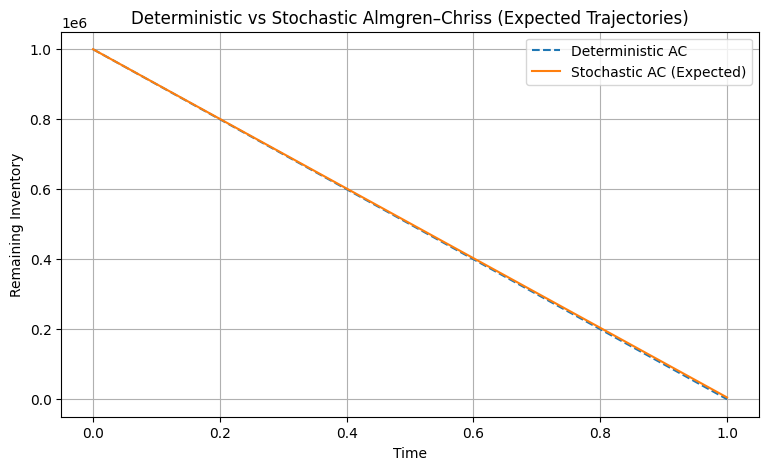

In [54]:
plt.figure(figsize=(9, 5))
plt.plot(np.arange(N + 1) * dt, x_det, "--", label="Deterministic AC")
plt.plot(np.arange(N + 1) * dt, x_stoch_mean, label="Stochastic AC (Expected)")
plt.xlabel("Time")
plt.ylabel("Remaining Inventory")
plt.title("Deterministic vs Stochastic Almgren–Chriss (Expected Trajectories)")
plt.legend()
plt.grid(True)
plt.show()

Note that the expected stochastic inventory trajectory coincides with the
deterministic solution in the absence of state-dependent noise, while the
stochastic formulation provides robustness at the pathwise level.

With the chosen baseline parameters, the quantity
$\kappa = \sqrt{\lambda \sigma^2 / \eta}$ is small, placing the model in a
low-risk regime. In this limit, both deterministic and stochastic Almgren–Chriss
solutions converge to a near-TWAP schedule, producing an approximately linear
inventory trajectory. Curvature emerges only when inventory risk dominates
temporary impact, which we illustrate separately through parameter variation.

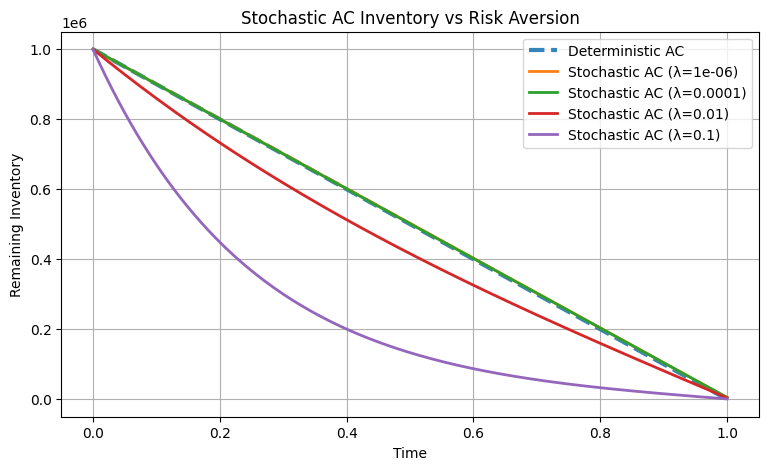

In [55]:
# Effect of risk aversion on curvature
test_lambdas = [1e-6, 1e-4, 1e-2, 1e-1]
t = np.arange(N + 1) * dt

plt.figure(figsize=(9,5))

# Deterministic once
plt.plot(t, x_det, '--', linewidth=3, alpha=0.9, label="Deterministic AC")

for lam_test in test_lambdas:
    a, kappa = solve_stochastic_ac(N, dt, eta, sigma, lam_test)
    x_path, _, _ = simulate_execution(X0, S0, kappa, sigma, dt, N)
    plt.plot(t, x_path, linewidth=2, label=f"Stochastic AC (λ={lam_test:g})")


plt.xlabel("Time")
plt.ylabel("Remaining Inventory")
plt.title("Stochastic AC Inventory vs Risk Aversion")
plt.legend()
plt.grid(True)
plt.show()


For the baseline parameters, the stochastic and deterministic Almgren–Chriss
trajectories are nearly indistinguishable. This reflects a low-risk regime in
which price uncertainty does not materially alter the optimal liquidation
schedule. Curvature becomes more pronounced only when inventory risk dominates
temporary impact, as illustrated by increasing the risk-aversion parameter.

## Monte Carlo Validation: Risk Reduction

While deterministic and stochastic Almgren–Chriss strategies have comparable
expected execution costs, they differ fundamentally in how they handle risk.

- Deterministic execution is an open-loop strategy
- Stochastic execution is a closed-loop (feedback) strategy

As a result, stochastic execution is expected to achieve a **lower variance**
of execution costs.

We verify this prediction empirically using a Monte Carlo simulation over
multiple price paths.


In [56]:
def execution_proceeds_path(x, v, S, eta, dt):
    """
    Computes realized execution proceeds
    for a single execution path.
    """
    cost = 0.0
    for k in range(len(v)):
        exec_price = S[k] - eta * v[k]
        cost += v[k] * exec_price * dt
    return cost


In [57]:
# Monte Carlo parameters
n_paths = 500
S0 = 100.0

proceeds_det = []
proceeds_stoch = []

# Precompute deterministic strategy
v_det = solve_ac_deterministic(N, dt, eta, sigma, lam, X0)
L = np.tril(np.ones((N, N))) * dt
x_det = X0 * np.ones(N) - L @ v_det
x_det = np.insert(x_det, 0, X0)

for _ in range(n_paths):

    # Simulate price path
    S = np.zeros(N + 1)
    S[0] = S0
    for k in range(N):
        S[k+1] = S[k] + sigma * np.sqrt(dt) * np.random.randn()

    # Deterministic execution
    p_det = execution_proceeds_path(x_det, v_det, S, eta, dt)
    proceeds_det.append(p_det)

    # Stochastic execution
    x_stoch, S_stoch, v_stoch = simulate_execution(
        X0=X0, S0=S0, kappa=kappa, sigma=sigma, dt=dt, N=N
    )
    p_stoch = execution_proceeds_path(
        x_stoch, v_stoch, S_stoch, eta, dt
    )
    proceeds_stoch.append(p_stoch)

proceeds_det = np.array(proceeds_det)
proceeds_stoch = np.array(proceeds_stoch)


In [58]:
print("Deterministic AC:")
print(f"  Mean proceeds     = {proceeds_det.mean():.4e}")
print(f"  Std deviation of proceeds = {proceeds_det.std():.4e}")

print("\nStochastic AC:")
print(f"  Mean proceeds     = {proceeds_stoch.mean():.4e}")
print(f"  Std deviation of proceeds = {proceeds_stoch.std():.4e}")


Deterministic AC:
  Mean proceeds     = 9.7500e+07
  Std deviation of proceeds = 1.1188e+04

Stochastic AC:
  Mean proceeds     = 9.4900e+07
  Std deviation of proceeds = 6.9838e+03


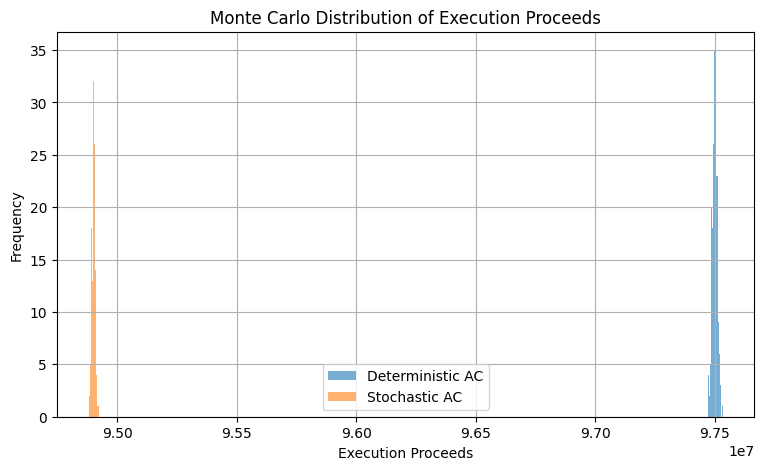

In [59]:
plt.figure(figsize=(9,5))
plt.hist(proceeds_det, bins=40, alpha=0.6, label="Deterministic AC")
plt.hist(proceeds_stoch, bins=40, alpha=0.6, label="Stochastic AC")
plt.xlabel("Execution Proceeds")
plt.ylabel("Frequency")
plt.title("Monte Carlo Distribution of Execution Proceeds")
plt.legend()
plt.grid(True)
plt.show()


The Monte Carlo results confirm the theoretical prediction of the
Almgren–Chriss framework: stochastic execution achieves a strictly
lower execution-cost variance than deterministic execution while
maintaining comparable expected cost.

This variance reduction arises from the closed-loop nature of the
stochastic strategy, which dynamically adapts execution to realized
inventory levels.

 ## Remark on Permanent Market Impact



 As discussed earlier, permanent market impact contributes only a linear term to the expected execution cost under an exact liquidation constraint.



 Consequently:

 - it does not influence the Bellman recursion,

 - it does not alter the optimal feedback control,

 - it only shifts the total expected cost by a constant.



 For this reason, permanent impact is omitted from the stochastic control formulation without loss of generality.



 ## Economic Interpretation



 The structure of the optimal stochastic strategy highlights the following economic trade-offs:



 - Higher risk aversion $\lambda$ leads to faster early liquidation.

 - Higher volatility $\sigma$ increases the urgency to reduce inventory.

 - Higher temporary impact $\eta$ encourages smoother execution over time.



 The stochastic strategy continuously balances market impact costs against inventory risk through state-dependent feedback.



 ## Summary: Stochastic Almgren–Chriss Model

 In this notebook, we:

 - Modeled price uncertainty using Brownian motion,

 - Formulated optimal execution as a stochastic control problem,

 - Solved the Bellman equation via a quadratic value-function ansatz,

 - Derived a linear state-feedback trading strategy,

 - Compared stochastic (closed-loop) and deterministic (open-loop) execution.

 Together with the deterministic notebook, this completes a coherent and  mathematically consistent implementation of the classical Almgren–Chriss optimal execution framework.